In [1]:
from xrr import XRR
from xrr_toolkit import file_dialog
from xrr_sorter import xrr_sorter
import ipywidgets as widgets
import warnings
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import pickle
from xrr_toolkit import save_dialog, open_dialog 

warnings.filterwarnings("ignore")

# Multi Loader

In [8]:
# with open(f'{save_dialog()}.pickle', 'wb') as handle:
#     pickle.dump(xrr_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(f'{open_dialog()}', 'rb') as handle:
    xrr_data = pickle.load(handle)

In [2]:
dir = file_dialog()

if dir.name == "CCD":
    xrr_sorter(dir)
    multi_dir = dir.parent.joinpath('Sorted')
elif dir.name == 'Sorted':
    multi_dir = dir

In [3]:
Energies = list(multi_dir.iterdir())
Energies

[WindowsPath('C:/Users/Harlan Heilman/Washington State University (email.wsu.edu)/Carbon Lab Research Group - Documents (1)/Synchrotron Logistics and Data/ALS - Berkeley/Data/BL1101/2023May/XRR/Merged Data/P100/Sorted/250.0'),
 WindowsPath('C:/Users/Harlan Heilman/Washington State University (email.wsu.edu)/Carbon Lab Research Group - Documents (1)/Synchrotron Logistics and Data/ALS - Berkeley/Data/BL1101/2023May/XRR/Merged Data/P100/Sorted/275.0'),
 WindowsPath('C:/Users/Harlan Heilman/Washington State University (email.wsu.edu)/Carbon Lab Research Group - Documents (1)/Synchrotron Logistics and Data/ALS - Berkeley/Data/BL1101/2023May/XRR/Merged Data/P100/Sorted/280.0'),
 WindowsPath('C:/Users/Harlan Heilman/Washington State University (email.wsu.edu)/Carbon Lab Research Group - Documents (1)/Synchrotron Logistics and Data/ALS - Berkeley/Data/BL1101/2023May/XRR/Merged Data/P100/Sorted/281.0'),
 WindowsPath('C:/Users/Harlan Heilman/Washington State University (email.wsu.edu)/Carbon Lab

In [5]:
xrr_data = {energy.name: XRR(energy) for energy in tqdm(Energies)}

  0%|          | 0/23 [00:00<?, ?it/s]

In [9]:
@widgets.interact(energy=[E.name for E in Energies])

def show_plots(energy):
    xrr = xrr_data[f"{energy}"]

    @widgets.interact(point=(0, xrr.refl.q.size - 1))
    def spot_checker(point=0):
        xrr.check_spot(point)

interactive(children=(Dropdown(description='energy', options=('250.0', '275.0', '280.0', '281.0', '281.2', '28…

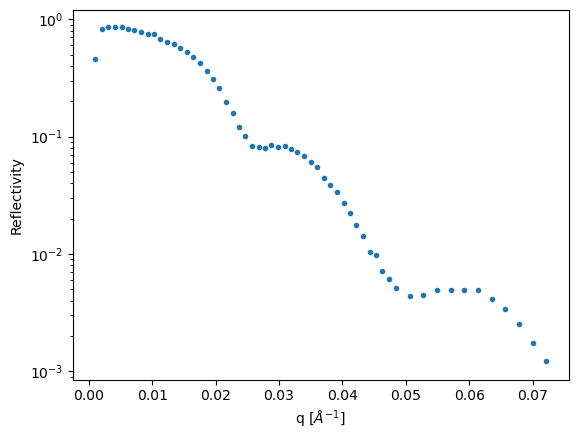

In [80]:
xrr_data['275.0'].refl.plot()

In [10]:
xrr1 = xrr_data['289.0']
mask = xrr1.images.generate_mask(1)
plt.imshow(mask)

TypeError: Images.generate_mask() takes 2 positional arguments but 3 were given

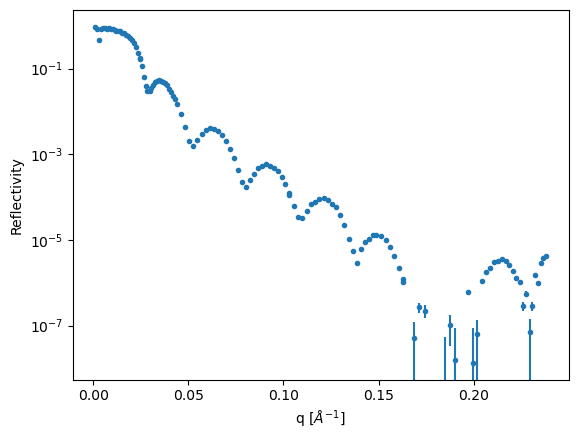

In [54]:
xrr1 = xrr_data['250.0']
xrr1.finalize()
xrr1.refl.plot()

In [55]:
dir2 = file_dialog()

In [58]:
xrr2 = XRR(dir2)

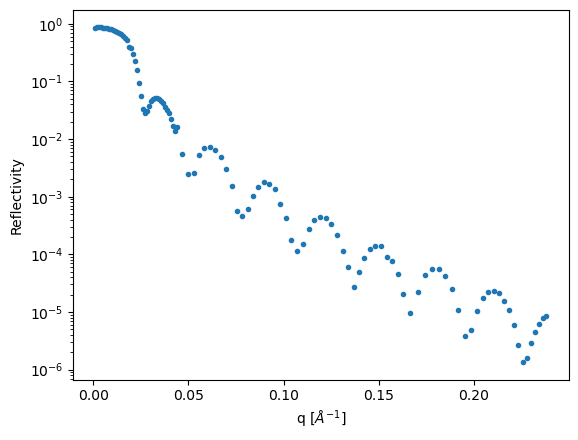

In [84]:
from matplotlib.ticker import MultipleLocator
xrr2.finalize()
xrr2.refl.plot()

# Fitting

In [11]:
import os.path
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py

from pypxr.reflectivity import *
from pypxr.structure import *

In [60]:
en = 280.0 #[eV]

si = PXR_MaterialSLD('Si', density=2.33, name='Si') #Substrate
sio2 = PXR_MaterialSLD('SiO2', density=2.28, name='SiO2') #Substrate
vacuum = PXR_MaterialSLD('', density=1, name='vacuum') #Superstrate


n_xx = complex(0.00184655422, 0.000366018445) # [unitless] #Ordinary Axis
n_zz = n_xx # [unitless] #Extraordinary Axis
znpc = PXR_SLD(np.array([n_xx, n_zz]), name='ZnPc') #Molecule

In [61]:
#Substrate objects
#(thickness, roughness)
si_slab = si(0, 0.5) #thickness of bounding substrate does not matter
sio2_slab = sio2(12, 1)
#Film bulk
znpc_slab = znpc(197.8, 2)

In [62]:
structure = vacuum | znpc_slab | sio2_slab | si_slab

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

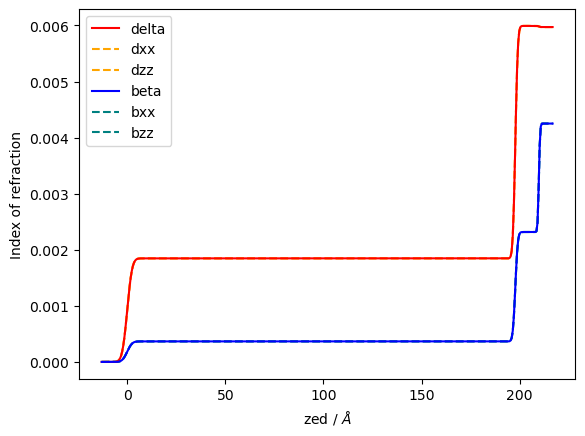

In [63]:
structure.plot()

In [64]:
model_spol = PXR_ReflectModel(structure, energy=en, pol='s', name=('spol'))
model_ppol = PXR_ReflectModel(structure, energy=en, pol='p', name=('ppol'))

In [65]:
from refnx.dataset import ReflectDataset # Object used to define data
from refnx.analysis import Transform, CurveFitter, Objective # For fitting

In [70]:
from uncertainties import unumpy as unp
q_s = xrr2.refl.q
r_s = unp.nominal_values(xrr2.refl.r)
r_s_err = unp.std_devs(xrr2.refl.r)
spol = np.column_stack((q_s,r_s,r_s_err))

q_p = xrr1.refl.q
r_p = unp.nominal_values(xrr1.refl.r)
r_p_err = unp.std_devs(xrr1.refl.r)
ppol = np.column_stack((q_p,r_p,r_p_err))
mydata = np.concatenate([spol, ppol])

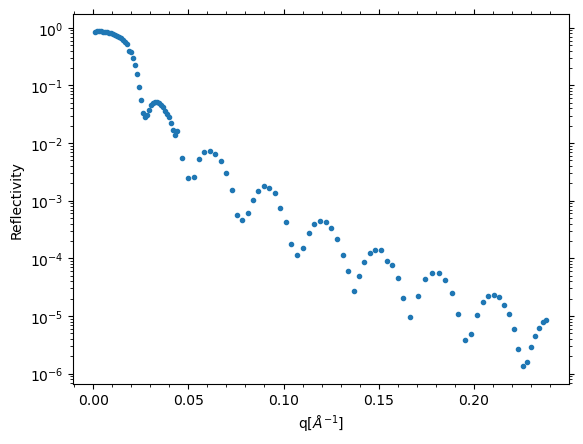

In [100]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.errorbar(q_s, r_s, r_s_err, fmt = '.')
ax.set_ylabel('Reflectivity')
ax.set_xlabel(r'q[$\AA^{-1}$]')

plt.tick_params(which = 'both', right=True, top=True)
plt.minorticks_on()

def Q2R(q):
    return (2*np.pi)/q

def R2Q(q):
    return (2*np.pi)/q

# secax = ax.secondary_xaxis('top', functions=(Q2R,R2Q))
# secax.set_xlabel('Secondary-X-Axis')

plt.show()

In [71]:
data = ReflectDataset(mydata.T)
model = PXR_ReflectModel(structure, energy=en, pol='sp')

(<Figure size 640x480 with 1 Axes>, <Axes: >)

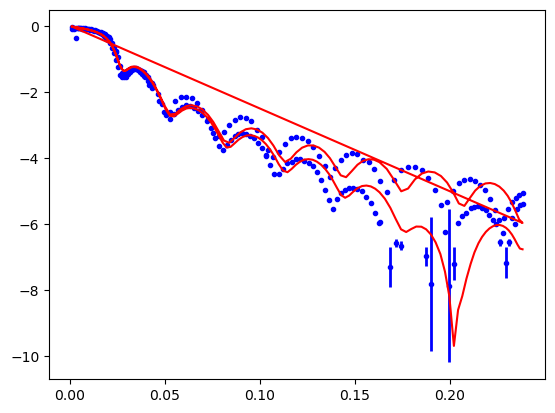

In [72]:
objective = Objective(model, data, transform=Transform('logY'))
objective.plot()

In [73]:
si_slab.thick.setp(vary=False)
si_slab.rough.setp(vary=True, bounds=(1,10))

sio2_slab.thick.setp(vary=True, bounds=(1,30))
sio2_slab.rough.setp(vary=True, bounds=(1,30))
sio2_slab.sld.density.setp(vary=False)

znpc_slab.thick.setp(vary=True, bounds=(400,900))
znpc_slab.rough.setp(vary=True, bounds=(0.2,20))
znpc_slab.sld.xx.setp(vary=False)
znpc_slab.sld.zz.setp(vary=False)
znpc_slab.sld.ixx.setp(vary=False)
znpc_slab.sld.izz.setp(vary=False)

In [74]:
print(objective.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter: 'ZnPc_thick'  , value=197.8          , bounds=[400.0, 900.0]>
<Parameter: 'ZnPc_rough'  , value=2          , bounds=[0.2, 20.0]>
<Parameter: 'SiO2_thick'  , value=12          , bounds=[1.0, 30.0]>
<Parameter: 'SiO2_rough'  , value=1          , bounds=[1.0, 30.0]>
<Parameter:  'Si_rough'   , value=0.5          , bounds=[1.0, 10.0]>


In [75]:
fitter = CurveFitter(objective, nwalkers=200)
# Optionalal change to the initialization. Begin chains near initial conditions
fitter.initialise(pos='jitter')

# Further Work

In [14]:
xrr_data['280.0'].raw_data.polarization

array([190., 190., 190., 190., 190., 190., 190., 190., 190., 190., 190.,
       190., 190., 190., 190., 190., 190., 190., 190., 190., 190., 190.,
       190., 190., 190., 190., 190., 190., 190., 190., 190., 190., 190.,
       190., 190., 190., 190., 190., 190., 190., 190., 190., 190., 190.,
       190., 190., 190., 190., 190., 190., 190., 190., 190., 190., 190.,
       190., 190., 190., 190., 190., 190., 190., 190., 190., 190., 190.,
       190., 190., 190., 190., 190., 190., 190., 190., 190., 190., 190.,
       190., 190., 190., 190., 190., 190., 190., 190., 190., 190., 190.,
       190., 190.])